## Neural networks 

Fully connected neural networks are a class of models that are widely used in machine learning. They are a generalization of linear models that perform multiple stages of processing to come to a decision. The power of neural networks comes from the ability to approximate any continuous function (universal approximation theorem). 

The schema of fully connected neural network is shown below.

![Fully connected neural network](fc_cap_all.png)


Each layer consists of a set of neurons. Each neuron takes the weighted sum of its inputs, adds a bias and applies an activation function. The output of the neuron is the result of the activation function. The output of the previous layer is the input to the next layer. The last layer is the output layer. The output of the network is the result of the activation function of the last layer.

The most common activation functions are:

* Sigmoid function: $\sigma(x) = \frac{1}{1 + e^{-x}}$
* Hyperbolic tangent: $tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
* Rectified linear unit: $ReLU(x) = max(0, x)$
* Softmax: $\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$

In order to train a neural network, we need to define a loss function that measures how good the predictions of the network are. The most common loss functions are:

* Mean squared error: $\frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2$
* Cross entropy: $-\frac{1}{n}\sum_{i=1}^n y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)$
* Multiclass cross entropy: $-\frac{1}{n}\sum_{i=1}^n \sum_{j=1}^m y_{ij} \log(\hat{y}_{ij})$

The loss function is used to update the weights of the network. The most common method for updating the weights is gradient descent. The gradient of the loss function with respect to the weights is calculated and the weights are updated in the direction opposite to the gradient. The amount of the update is determined by the learning rate. This procedure is equivalent to minimizing the loss function. 


In this lab we will use pytorch to implement a neural network. Pytorch is a deep learning framework that provides automatic differentiation for building and training neural networks. It is similar to tensorflow, but it is more flexible and easier to use. Then we will use the neural network to classify images from the MNIST dataset.

In [1]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Let's visualize the MNIST dataset. The dataset consists of 70,000 images of handwritten digits. Each image is 28x28 pixels. The images are grayscale, so each pixel is represented by a single value between 0 and 255. The labels are the digits that the images represent.

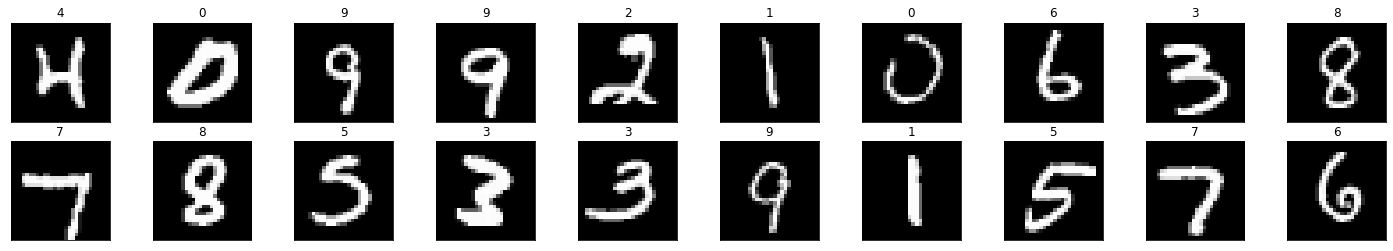

In [3]:
# Visualize some of the images
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

dataiter = iter(train_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))


OK, now let's train our network

In [4]:
import torch
import torch.optim as optim

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

# set the device to cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device: ', device)

# move the model to the device
net.to(device)

epochs = 10
train_loss = []
test_loss = []
for e in range(epochs):
    print(f"Epoch: {e+1}/{epochs}")
    running_loss = 0
    for images, labels in train_loader:
        # move the images and labels to the device
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss.append(running_loss/len(train_loader))
    print(f"Training loss: {running_loss/len(train_loader)}")

    with torch.no_grad():
        correct = 0
        total = 0
        running_test_loss = 0
        
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = net(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(output, labels)
            running_test_loss += loss.item()
        
        test_loss.append(running_test_loss/len(test_loader))
        print(f"Test accuracy: {correct/total}\n")

Using device:  cuda
Epoch: 1/10
Training loss: 0.5935599425041092
Test accuracy: 0.91

Epoch: 2/10
Training loss: 0.302148704474637
Test accuracy: 0.9268

Epoch: 3/10
Training loss: 0.25500250204222036
Test accuracy: 0.9333

Epoch: 4/10
Training loss: 0.22346482653099337
Test accuracy: 0.94

Epoch: 5/10
Training loss: 0.1993893632994913
Test accuracy: 0.9462

Epoch: 6/10
Training loss: 0.18009347067689147
Test accuracy: 0.9511

Epoch: 7/10
Training loss: 0.16395052582589484
Test accuracy: 0.9537

Epoch: 8/10
Training loss: 0.15090569513025823
Test accuracy: 0.9576

Epoch: 9/10
Training loss: 0.13973018700983733
Test accuracy: 0.959

Epoch: 10/10
Training loss: 0.1297131766583016
Test accuracy: 0.9622



Plot the loss and accuracy on the training and validation sets during training.

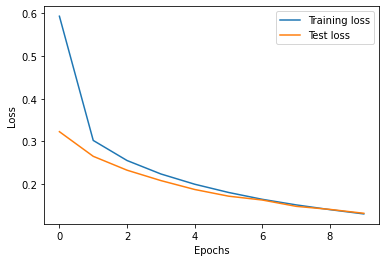

In [5]:
# Plot the training and test loss
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Test the network on the test set

In [6]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy: {correct/total}")

Accuracy: 0.9622


## Contest
Train a neural network for CIFAR-10 classification. The dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5,000 images from each class.

Hints:
* Use mulitclass cross entropy loss (nn.CrossEntropyLoss)
* Try different architectures
* Try different hyperparameters (learning rate, batch size, etc.)


In [7]:
import torchvision
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Visualize some images from the dataset.

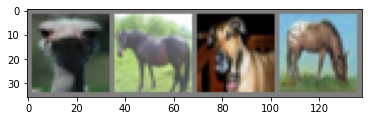

bird  horse dog   horse


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))